# LANGCHAIN

In [1]:
from typing import List, TypedDict
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_qdrant import Qdrant
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.schema import Document


In [2]:
#note: pypdf also records title, page numeber etc required by chain-5

from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader

#loader = DirectoryLoader('/home/tom/Python/Tools/RAG and PDF/docs', glob="**/*.pdf", loader_cls=UnstructuredPDFLoader, show_progress=True)
loader = DirectoryLoader('docs', glob="**/*.pdf", loader_cls=PyMuPDFLoader, show_progress=True)
repo_files = loader.load()


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


In [3]:

print(f"Number of files loaded: {len(repo_files)}")
#
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=150)
documents = text_splitter.split_documents(documents=repo_files)
print(f"Number of documents : {len(documents)}")

Number of files loaded: 13
Number of documents : 63


In [4]:
from langchain_ollama import OllamaEmbeddings
#from langchain_community.vectorstores import Qdrant
from langchain_qdrant import Qdrant

In [5]:
model_name = "nomic-embed-text"
embeddings = OllamaEmbeddings(model=model_name)

In [6]:
#Restore db

qdrant = Qdrant.from_existing_collection(
 embeddings,
 path="langchain_local_qdrant_pdf_orig",
 collection_name="my_documents",
)

In [7]:
retriever = qdrant.as_retriever()

In [8]:
import os
api_key = 'PUT THE KEY HERE'
#os.environ["OPENAI_API_KEY"] = api_key

### use it as an llm

In [9]:
import requests
import json


response = requests.post(
    url="https://openrouter.ai/api/v1/chat/completions",
    headers={
        "Authorization": f"Bearer {api_key}",
    },
    data=json.dumps({
        "model": "deepseek/deepseek-r1-distill-llama-70b:free",  # Optional
        "messages": [
            {
                "role": "user",
                "content": "What is the meaning of life?"
            }
        ],
        "provider": {
            "order": [
                "Together",
                "Targon"              
            ]
        }
    })
)


In [10]:
# Check for errors and print response
if response.status_code == 200:
    result = response.json()
    print(result["choices"][0]["message"]["content"])
else:
    print(f"Error: {response.status_code}, {response.text}")

The meaning of life is a deeply personal and subjective question, with answers varying widely among individuals. Here are the key points that encapsulate the exploration:

1. **Diverse Perspectives**: Different people have varied beliefs, ranging from religious views, scientific explanations, to philosophical stances like existentialism, which emphasizes self-defined meaning.

2. **Personal Fulfillment**: Each individual may find their own meaning through personal growth, relationships, career, or hobbies, suggesting that life's meaning is not universal but unique to each person.

3. **Evolutionary View**: From a scientific perspective, life's purpose might be tied to survival and reproduction, yet humans often seek more complex forms of meaning beyond basic instincts.

4. **Dynamic Meaning**: The meaning of life can evolve over time, influenced by different life stages and experiences, shifting from growth and learning to legacy and contribution.

5. **Happiness and Contentment**: Whi

### definition for llm in langchain (doesnt have tool integration)

In [10]:
from langchain_core.language_models import LLM
import requests
import json

class OpenRouterLLM(LLM):
    openrouter_api_key: str
    model: str
    provider_order: list

    def _call(self, prompt: str, stop=None) -> str:
        """Calls OpenRouter API and returns a response."""
        headers = {
            "Authorization": f"Bearer {self.openrouter_api_key}",
            "Content-Type": "application/json",
        }

        data = {
            "model": self.model,
            "messages": [{"role": "user", "content": prompt}],
            "provider": {"order": self.provider_order},  # Provider preference
        }

        response = requests.post(
            url="https://openrouter.ai/api/v1/chat/completions",
            headers=headers,
            data=json.dumps(data)
        )

        if response.status_code == 200:
            result = response.json()
            return result["choices"][0]["message"]["content"]
        else:
            raise ValueError(f"Error {response.status_code}: {response.text}")

    @property
    def _identifying_params(self):
        """Defines unique parameters for this LLM."""
        return {"model": self.model, "provider_order": self.provider_order}

    @property
    def _llm_type(self):
        return "custom_openrouter"



# Define LLM with provider preference
llm = OpenRouterLLM(
    openrouter_api_key=api_key,
    model="deepseek/deepseek-r1-distill-llama-70b:free",
    #model="qwen/qwen-turbo",
    #model="qwen/qwen-vl-plus:free",
    #model="qwen/qwen-turbo",    
    provider_order=["Alibaba", "Together", "Targon"]  # Provider preference
)        

LLM_TYPE="custom"

### llm definition using openai config

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
        temperature=0.7,
        model="qwen/qwen-turbo", 
        openai_api_key=api_key,
        openai_api_base="https://openrouter.ai/api/v1",
        #provider_order=['DeepInfra','Together'],
        #headers={"HTTP-Referer": constants.OPENROUTER_REFERRER},    
    )

LLM_TYPE="openai_type"

In [10]:
#local_model = "llama3.2"
#llm = ChatOllama(model=local_model)
#LLM_TYPE="ollama"

## METHOD 1: FAST REPLY

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
Prompt: ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])
chain = prompt | llm | StrOutputParser()


chunks_answer = []
for chunk in chain.stream({"question":query,"context":found_docs}):
    print(chunk, end='')
    chunks_answer.append(chunk)

## METHOD 2 : NO TOOL OR MEMORY , BUT SOURCES (compatable with all llms including qwen/qwen-vl-plus:free)

In [20]:
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = qdrant.similarity_search(state["question"])
    return {"context": retrieved_docs}

#use this generate function in case of openai format or ollama.
def generate_orig(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

##use this generate function in case of openrouter from scratch (llm in langhain)
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    
    # Ensure the correct format for messages
    messages = prompt.invoke({"question": state["question"], "context": docs_content})

    # OpenRouterLLM returns a string, so no `.content` attribute
    response_text = llm.invoke(messages)  # This is already a string

    return {"answer": response_text}  # Directly return the string
    

/home/tom/apps/cache/python-envs/ML/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [21]:
# Compile application and test

if LLM_TYPE == "ollama" or LLM_TYPE == "openai_type":
    graph_builder = StateGraph(State).add_sequence([retrieve, generate_orig])

if LLM_TYPE == "custom":
    graph_builder = StateGraph(State).add_sequence([retrieve, generate])

graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

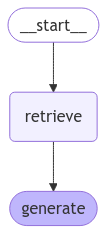

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
result = graph.invoke({"question": "What is value network?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'docs/todi2021.pdf', 'file_path': 'docs/todi2021.pdf', 'page': 7, 'total_pages': 13, 'format': 'PDF 1.7', 'title': 'Adapting User Interfaces with Model-based Reinforcement Learning', 'author': 'Kashyap Todi', 'subject': '-  Human-centered computing  ->  Interactive systems and tools.', 'keywords': 'Adaptive User Interfaces; Reinforcement Learning; Predictive Models; Monte Carlo Tree Search', 'creator': 'LaTeX with acmart 2020/11/15 v1.75 Typesetting articles for the Association for Computing Machinery and hyperref 2018/02/06 v6.86b Hypertext links for LaTeX', 'producer': 'pdfTeX-1.40.19', 'creationDate': 'D:20210314174636Z', 'modDate': "D:20210318182844+02'00'", 'trapped': '', '_id': 'cad0e432b27849789d833f9fd19fc6cb', '_collection_name': 'my_documents'}, page_content='then passed to a fully connected layer. Finally, the click history \nis passed to an LSTM layer, which models sequential data and is \nDesign Data\nCurrent\nMatrix\nAdapted\nMatrix\

In [ ]:
result

## METHOD 3 : WITH MEMORY AND SOURCES (needs tool support in model, works with ollama and other paid models)

In [12]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = qdrant.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [13]:
from langchain_core.messages import SystemMessage
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
import re
from langchain_core.messages import AIMessage, HumanMessage
import json


class State(MessagesState):
    context: List[Document]

def create_prompt(state: State):
    """Formats the chat history and retrieved context into a proper prompt."""
    history = [
        message for message in state["messages"] if isinstance(message, (AIMessage, HumanMessage))
    ]
    
    docs_content = "".join(state.get("context", []))  # Retrieved documents
    system_message = SystemMessage(
        "You are an assistant for question-answering tasks. "
        "Use the following retrieved context to provide answers. "
        "If the answer isn't available in the context, say you don't know."
        f"\n\nContext:\n{docs_content}"
    )

    return [system_message] + history



# Step 1: Generate an AIMessage that may include a tool-call to be sent.

#use this generate function in case of openai format or ollama.
def query_or_respond_orig(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve]) 
    response = llm_with_tools.invoke(state["messages"]) 
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

#use this generate function in case of openrouter from scratch (llm in langhain)
def query_or_respond(state: State):
    """Determine whether to retrieve documents or respond directly."""
    user_message = state["messages"][-1]  # Get the latest user message

    retrieved_docs = retrieve.invoke({"query": user_message.content})

    #print('retreived docs 1',retrieved_docs)
    
    state['context'] = retrieved_docs
    # Proceed with processing
    prompt = create_prompt({"messages": state["messages"], "context": state["context"]})
    response_text = llm.invoke(prompt)
    response = AIMessage(content=response_text)
    
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
#use this generate function in case of openai format or ollama.
def generate_orig(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    context = []
    for tool_message in tool_messages:
        context.extend(tool_message.artifact)
    return {"messages": [response], "context": context}


#use this generate function in case of openrouter from scratch (llm in langhain)
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    print('executed')
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run LLM
    response_text = llm.invoke(prompt)  # OpenRouterLLM returns a string

    # Convert response string into AIMessage (fixes the issue)
    response = AIMessage(content=response_text)

    # Extract context from tool messages
    context = []
    for tool_message in tool_messages:
        context.extend(tool_message.artifact)

    return {"messages": [response], "context": context}    

In [14]:
graph_builder = StateGraph(MessagesState)


if LLM_TYPE == "ollama" or LLM_TYPE == "openai_type":
    graph_builder.add_node(query_or_respond_orig)
    graph_builder.add_node(tools)
    graph_builder.add_node(generate_orig)
    
    graph_builder.set_entry_point("query_or_respond_orig")
    graph_builder.add_conditional_edges(
        "query_or_respond_orig",
        tools_condition,
        {END: END, "tools": "tools"},
    )
    graph_builder.add_edge("tools", "generate_orig")
    graph_builder.add_edge("generate_orig", END)

if LLM_TYPE == "custom":
    graph_builder.add_node(query_or_respond)
    graph_builder.add_node(tools)
    graph_builder.add_node(generate)
    
    graph_builder.set_entry_point("query_or_respond")
    graph_builder.add_conditional_edges(
        "query_or_respond",
        tools_condition,
        {END: END, "tools": "tools"},
    )
    graph_builder.add_edge("tools", "generate")
    graph_builder.add_edge("generate", END)

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

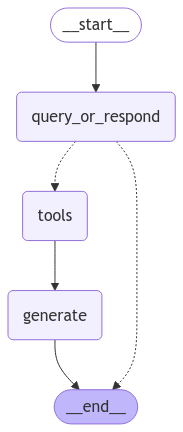

In [15]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_message = "tell me about mcts"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

tell me about mcts


In [17]:
input_message = "whats value network?"

response = graph.invoke({"messages": [{"role": "user", "content": input_message}]},config,stream_mode="values",)


In [ ]:
response

## METHOD 4: CONVERSATIONAL RAG CHAIN (supports all)

In [17]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory

### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)



In [18]:
chunks = []
for chunk in conversational_rag_chain.stream({"input": "tell me a bit more?"}, config={"configurable": {"session_id": "abc123"}}):
    chunks.append(chunk)
    if 'answer' in chunk:
        print(chunk['answer'], end='')
    else:
        pass

The system uses a neural network architecture to predict value estimates for adaptive interfaces, handling design and user features through concatenated branches. It leverages Monte Carlo Tree Search (MCTS) for training data generation and processes sequential user interactions using LSTM layers. This setup allows efficient, real-time predictions without costly simulations, supporting dynamic applications effectively.

In [19]:
result = conversational_rag_chain.invoke({"input": "what is value network?"}, config={"configurable": {"session_id": "abc123"}})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'docs/todi2021.pdf', 'file_path': 'docs/todi2021.pdf', 'page': 4, 'total_pages': 13, 'format': 'PDF 1.7', 'title': 'Adapting User Interfaces with Model-based Reinforcement Learning', 'author': 'Kashyap Todi', 'subject': '-  Human-centered computing  ->  Interactive systems and tools.', 'keywords': 'Adaptive User Interfaces; Reinforcement Learning; Predictive Models; Monte Carlo Tree Search', 'creator': 'LaTeX with acmart 2020/11/15 v1.75 Typesetting articles for the Association for Computing Machinery and hyperref 2018/02/06 v6.86b Hypertext links for LaTeX', 'producer': 'pdfTeX-1.40.19', 'creationDate': 'D:20210314174636Z', 'modDate': "D:20210318182844+02'00'", 'trapped': '', '_id': 'dc11c6746b0246b4aad20597660a17c1', '_collection_name': 'my_documents'}, page_content='unexplored states. \n...\n...\n...\n...\nConcatenation\nInput Branches \n(Model)\nInput\nDesign\nFeatures\nUser\nFeatures\nOutput Branches\n(Model)\nValue\nPredictions\nModel-based\

## METHOD 5: AGENT EXECUTOR METHOD (support ollama and paid models, doesnt work with openrouter from scratch (custom))

In [31]:
from langchain.tools.retriever import create_retriever_tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage
### Build retriever tool ###
tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]
memory = MemorySaver()

agent_executor = create_react_agent(llm, tools, checkpointer=memory)

In [32]:
query = "How was it implemented?"
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

for s in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]}, config=config
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content="It seems like your question is about a specific implementation, but it lacks context regarding what you're referring to. Could you please provide more details? For instance, are you asking about the implementation of a certain feature on a website, an algorithm, or perhaps a project related to autonomous agents? The more specifics you can give me, the better I can assist you with your query.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 190, 'total_tokens': 266, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen/qwen-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-14d7e0af-ff71-4456-8ed2-34d5974f75a8-0', usage_metadata={'input_tokens': 190, 'output_tokens': 76, 'total_tokens': 266, 'input_token_details': {}, 'output_token_details': {}})]}}
----


In [ ]:
query = "whats value network?"
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

response = agent_executor.invoke({"messages": [HumanMessage(content=query)]}, config=config)

In [ ]:
response

# LLAMAINDEX

In [ ]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader("docs4").load_data()

In [ ]:
#import ollama
from llama_index.llms.ollama import Ollama

llm = Ollama(model="llama3.1", request_timeout=300.0)
#llm = Ollama(model="llama3",base_url="http://192.168.1.232:11435") #llm = Ollama(model="llama2")

In [ ]:
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings,
    ServiceContext,
    StorageContext,
    load_index_from_storage,
)

from llama_index.core.tools import QueryEngineTool, ToolMetadata

In [ ]:
#embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
#from llama_index.embeddings.huggingface import HuggingFaceEmbedding


from llama_index.embeddings.ollama import OllamaEmbedding

ollama_embedding = OllamaEmbedding(
    model_name="mxbai-embed-large",
    #base_url="http://localhost:11434",
    ollama_additional_kwargs={"mirostat": 0},
)

In [ ]:
#set global parameters
from llama_index.core.node_parser import SentenceSplitter

Settings.llm = llm
Settings.embed_model = ollama_embedding
Settings.node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)
Settings.num_output = 512
Settings.context_window = 3900


In [ ]:
#Save to disc (Only execute this block if you have additional documents to be added to the database)

import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex


client = qdrant_client.QdrantClient(path="./llamaindex_local_qdrant_pdf")

vector_store = QdrantVectorStore(client=client, collection_name="usability")

storage_context = StorageContext.from_defaults(vector_store=vector_store)
index_usability = VectorStoreIndex.from_documents( documents, storage_context=storage_context, embed_model=ollama_embedding, llm=llm, node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20), num_output = 512, context_window = 3900, show_progress=True)

index_usability.storage_context.persist(persist_dir="./llamaindex_local_qdrant_pdf")

In [ ]:
#Load from disc
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex


client = qdrant_client.QdrantClient(path="./llamaindex_local_qdrant_pdf")

vector_store = QdrantVectorStore(client=client, collection_name="usability")

storage_context = StorageContext.from_defaults(vector_store=vector_store, persist_dir="./llamaindex_local_qdrant_pdf")

index_usability = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=ollama_embedding, llm=llm, node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20), num_output = 512, context_window = 3900)

### Q AND A

In [ ]:
from llama_index.core import Prompt
from llama_index.core import PromptTemplate

template = (
    "We have provided trusted context information below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given this trusted and cientific information, please answer the question: {query_str}. Remember that the statements of the context are verfied and come from trusted sources.\n"
)
qa_template = Prompt(template)

new_summary_tmpl_str = (
    "The original query is as follows: {query_str}"
    "We have provided an existing answer: {existing_answer}"
    "We have the opportunity to refine the existing answer (only if needed) with some more trusted context below. Remember that the statements of the context are verfied and come from trusted sources."
    "------------"
    "{context_msg}"
    "------------"
    "Given the new trusted context, refine the original answer to better answer the query. If the context isn't useful, return the original answer. Remember that the statements of the new context are verfied and come from trusted sources."
    "Refined Answer: sure thing! "
)
new_summary_tmpl = PromptTemplate(new_summary_tmpl_str)

In [ ]:
from llama_index.core.retrievers import BaseRetriever, VectorIndexRetriever, KeywordTableSimpleRetriever
from llama_index.core import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine

retriever = VectorIndexRetriever(
    index=index_usability,
    similarity_top_k=4, # Change this to lower value for higher performance
)

response_synthesizer = get_response_synthesizer( ##try compact?
    text_qa_template=qa_template,
    streaming=True,
    refine_template=new_summary_tmpl
)
query_engine3 = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    # node_postprocessors=[
    #     SimilarityPostprocessor(similarity_cutoff=0.7)
    # ]
)

In [ ]:
response = query_engine3.query("Explain value network?")

In [ ]:
response.print_response_stream()

In [ ]:
print(response)

### chat

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core.chat_engine import CondenseQuestionChatEngine

custom_prompt = PromptTemplate(
    """\
Given a conversation (between Human and Assistant) and a follow up message from Human, \
rewrite the message to be a standalone question that captures all relevant context \
from the conversation.

<Chat History>
{chat_history}

<Follow Up Message>
{question}

<Standalone question>
"""
)

# list of `ChatMessage` objects
custom_chat_history = [
    ChatMessage(
        role=MessageRole.USER,
        content="Hello assistant, we are having a insightful discussion about Additive Manufacturing today.",
    ),
    ChatMessage(role=MessageRole.ASSISTANT, content="Okay, sounds good."),
]

#query_engine = index_usability.as_query_engine()
chat_engine = CondenseQuestionChatEngine.from_defaults(
    query_engine=query_engine3,
    streaming=True,
    #condense_question_prompt=custom_prompt,
    #chat_history=custom_chat_history,
    #verbose=True,
)

In [ ]:
response = chat_engine.stream_chat("what all is composed in value network?")

In [ ]:
response.print_response_stream()

In [ ]:
from IPython.display import Markdown, display
display(Markdown(f"<b>{response}</b>"))

### sources available only in Q an A

In [ ]:
response.metadata

In [ ]:
import re
if hasattr(response, 'metadata'):
    document_info = str(response.metadata)
    find = re.findall(r"'page_label': '[^']*', 'file_name': '[^']*'", document_info)

    print('\n'+'=' * 60+'\n')
    print('Context Information')
    print(str(find))
    print('\n'+'=' * 60+'\n')